In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString





!wget -O cities.csv https://raw.githubusercontent.com/dr5hn/countries-states-cities-database/master/csv/cities.csv

df = pd.read_csv('cities.csv', on_bad_lines='skip')

crs={'init':'epsg:4326'}
US_map = gpd.read_file('/content/Us_map/tl_2023_us_state.shp')
US_map = US_map.to_crs("EPSG:4326")


world_map = gpd.read_file('/content/World_map/world-administrative-boundaries.shp')
world_map = world_map.to_crs("EPSG:4326")






--2024-04-23 01:19:02--  https://raw.githubusercontent.com/dr5hn/countries-states-cities-database/master/csv/cities.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13446898 (13M) [text/plain]
Saving to: ‘cities.csv’

cities.csv          100%[===================>]  12.82M  --.-KB/s    in 0.09s   

2024-04-23 01:19:03 (144 MB/s) - ‘cities.csv’ saved [13446898/13446898]



In [2]:
"""distance function - given 2 pairs of lat/lon coordinates it will find the distance between them (weights)
it takes into consideration the shape of the earth using haversine formula
based on source: https://www.geeksforgeeks.org/haversine-formula-to-find-distance-between-two-points-on-a-sphere/
"""
import math

def distance (loc_1:object, loc_2:object):

  lon1, lat1 = loc_1  # the two locations we are comparing distances for
  lon2, lat2 = loc_2

  #convert degrees to radians
  lon1 = math.radians(lon1)
  lon2 = math.radians(lon2)
  lat1 = math.radians(lat1)
  lat2 = math.radians(lat2)


  lon_dist = lon2-lon1
  lat_dist = lat2-lat1

  #conversion
  a = math.sin(lat_dist/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(lon_dist/2)**2
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
  miles_radius = 3958.8 #approximate radius of earth
  d = c * miles_radius
  d = round(d,4)
  return d

#test example - note its passed in as lon, lat
#distance([-99.436554, 41.507483], [-98.315949, 38.504048]) should return 215.8222

In [3]:
""" defining adjacency matrix graph """
def initialize_adjacency_matrix(df, selected_cities):
    # Filter the DataFrame to include only selected cities
    #filtered_df = df[df['name'].isin(selected_cities)]

    # Create an empty adjacency matrix
    n = len(selected_cities)
    adjacency_matrix = np.full((n, n), float('inf'))

    # Fill the adjacency matrix with distances between selected cities
    for i in range(n):
        city1 = selected_cities[i]
        city1_data = city1 #filtered_df[filtered_df['name'] == city1]
        for j in range(n):
            if i == j:
                adjacency_matrix[i, j] = 0  # Distance to itself is 0
            else:
                city2 = selected_cities[j]
                city2_data = city2 #filtered_df[filtered_df['name'] == city2]

                if not city1_data.empty and not city2_data.empty:
                    loc1 = (city1_data['longitude'].values[0], city1_data['latitude'].values[0])
                    loc2 = (city2_data['longitude'].values[0], city2_data['latitude'].values[0])

                    dist = distance(loc1, loc2)

                    #print(f"Distance between {city1['name'].values[0]} and {city2['name'].values[0]}: {dist} miles")  # Debugging statement

                    adjacency_matrix[i, j] = dist
                    adjacency_matrix[j, i] = dist

    return adjacency_matrix

In [4]:
# Prims algorithm
def prims_algorithm(adj_matrix, start_loc, n, selected_cities, filtered_cities_df):
    visited = [False] * n  # Tracking list
    mst = []              # MST edges
    current_loc = start_loc
    visited[current_loc] = True

    while True:
        min_distance = float('inf')
        next_loc = -1

        # Find closest location that's not visited
        for i in range(n):
            if visited[i] or adj_matrix[current_loc][i] == float('inf'):
                continue
            if adj_matrix[current_loc][i] < min_distance:
                min_distance = adj_matrix[current_loc][i]
                next_loc = i

        # When all locations have been visited
        if next_loc == -1:
            break

        visited[next_loc] = True

        mst.append((filtered_cities_df[current_loc], filtered_cities_df[next_loc], min_distance))

        #print(f"Edge added to MST: {current_loc} -> {next_loc}, distance: {min_distance} miles")  # Debugging statement

        current_loc = next_loc

    return mst


In [48]:
def UX_display(mst_prims, mst_kruskals, df, US_map, world_map):
  crs={'init':'epsg:4326'}

  cities = gpd.GeoDataFrame()
  countries = set()


  for city1, city2, distance in mst_kruskals:
    # adding the city's country
    countries.add(city1['country_name'].values[0])
    countries.add(city2['country_name'].values[0])
    # merging all the city data frames under one data frame
    cities = pd.concat([cities, city1])
    cities = pd.concat([cities, city2])

  cities = cities.drop_duplicates() #deleting the duplicates
  # creating single column "geometry" that holds a point with the city;s long and lat
  cities['geometry'] = cities.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
  # creating a new data frame only containing the geometry column
  cities_gdf = gpd.GeoDataFrame(cities, geometry='geometry', crs=crs)


  #initializng the list of lines that will be conecting the two cities
  lines = []

  for i in range(len(cities_gdf) - 1):
    start_point = cities_gdf['geometry'].iloc[i]
    end_point = cities_gdf['geometry'].iloc[i + 1]
    #creating a shapely LineString object
    line = LineString([start_point, end_point])
    # adding the line to the list
    lines.append(line)

  # creating a lines data frame from the lines
  lines_gdf = gpd.GeoDataFrame(geometry=lines, crs=crs)


  if len(countries) > 1: # cities span multiple countries, using world map
    # plotting it under one axis
    fig, axis = plt.subplots(figsize = (10,8))
    # title
    plt.title('Kruskals Algorithm', fontsize=20)
    # removing the axis labels
    plt.xticks([])
    plt.yticks([])
    # plotting the city points, lines, and map ontop of each other
    world_map.plot(ax = axis, cmap = 'twilight', edgecolor = 'black')
    # plotting the points names
    for idx, row in cities.iterrows():
        plt.annotate(text=row['name'], xy=(row['geometry'].x, row['geometry'].y), xytext=(3, 3), textcoords='offset points', color='#27b32c')
    cities_gdf.plot(ax = axis,markersize=50)
    lines_gdf.plot(ax = axis,markersize=10)
  else: # cities are only in one country, going to use that countries map
    if 'United States' in countries: # checks if the country is the united states
      non_continental = ['HI','VI','MP','GU','AK','AS','PR']
      us49 = US_map
      # removing non continetal states so the map is better
      for n in non_continental:
          us49 = us49[us49.STUSPS != n]
          cities = cities[cities['state_code'] != n]
      # plotting it under one axis
      fig, axis = plt.subplots(figsize = (10,8))
      # title
      plt.title('Kruskals Algorithm', fontsize=20)
      # removing the axis labels
      plt.xticks([])
      plt.yticks([])
      # plotting the city points, lines, and map ontop of each other
      us49.plot(ax = axis, cmap = 'twilight', edgecolor = 'black')
      # plotting the points names
      for idx, row in cities.iterrows():
        plt.annotate(text=row['name'], xy=(row['geometry'].x, row['geometry'].y), xytext=(3, 3), textcoords='offset points', color='#27b32c')
      cities_gdf.plot(ax = axis,markersize=50)
      lines_gdf.plot(ax = axis,markersize=10)

    else: # the country is not the united states, so going to find that country
      # takes the countries name
      country = list(countries)[0]
      # looks in world map data frame for that country
      map = world_map[world_map['name'] == country]

      fig, axis = plt.subplots(figsize = (10,8))
      plt.title('Kruskals Algorithm', fontsize=20)
      plt.xticks([])
      plt.yticks([])
      map.plot(ax = axis, cmap = 'twilight', edgecolor = 'black')
      # plotting the points names
      for idx, row in cities.iterrows():
        plt.annotate(text=row['name'], xy=(row['geometry'].x, row['geometry'].y), xytext=(3, 3), textcoords='offset points', color='#27b32c')
      cities_gdf.plot(ax = axis,markersize=50)
      lines_gdf.plot(ax = axis,markersize=10)

# doing the same thing but with mst prims
  cities = gpd.GeoDataFrame()
  countries = set()


  for city1, city2, distance in mst_prims:
    # adding the city's country
    countries.add(city1['country_name'].values[0])
    countries.add(city2['country_name'].values[0])
    # merging all the city data frames under one data frame
    cities = pd.concat([cities, city1])
    cities = pd.concat([cities, city2])

  cities = cities.drop_duplicates()
  cities['geometry'] = cities.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
  cities_gdf = gpd.GeoDataFrame(cities, geometry='geometry', crs=crs)
  lines = []


  for i in range(len(cities_gdf) - 1):
    start_point = cities_gdf['geometry'].iloc[i]
    end_point = cities_gdf['geometry'].iloc[i + 1]
    line = LineString([start_point, end_point])
    lines.append(line)


  city_points = gpd.GeoDataFrame(cities,crs=crs, geometry='geometry')
  lines_gdf = gpd.GeoDataFrame(geometry=lines, crs=crs)

  if len(countries) > 1: # cities span multiple countries, using world map
    fig, axis = plt.subplots(figsize = (10,8))
    plt.title('Prims Algorithm', fontsize=20)
    plt.xticks([])
    plt.yticks([])
    world_map.plot(ax = axis, cmap = 'twilight', edgecolor = 'black')
    # plotting the points names
    for idx, row in cities.iterrows():
      plt.annotate(text=row['name'], xy=(row['geometry'].x, row['geometry'].y), xytext=(3, 3), textcoords='offset points', color='#27b32c')
    cities_gdf.plot(ax = axis,markersize=50)
    lines_gdf.plot(ax = axis,markersize=10)
  else: # cities are only in one country, going to use that countries map
    if 'United States' in countries: # checks if the country is the united states
      non_continental = ['HI','VI','MP','GU','AK','AS','PR']
      us49 = US_map
      for n in non_continental:
          us49 = us49[us49.STUSPS != n]
          cities = cities[cities['state_code'] != n]
      fig, axis = plt.subplots(figsize = (10,8))
      plt.title('Prims Algorithm', fontsize=20)
      plt.xticks([])
      plt.yticks([])
      us49.plot(ax = axis, cmap = 'twilight', edgecolor = 'black')
      # plotting the points names
      for idx, row in cities.iterrows():
        plt.annotate(text=row['name'], xy=(row['geometry'].x, row['geometry'].y), xytext=(3, 3), textcoords='offset points', color='#27b32c')
      cities_gdf.plot(ax = axis,markersize=50)
      lines_gdf.plot(ax = axis,markersize=10)

    else: # the country is not the united states, so going to find that country
      country = list(countries)[0]
      map = world_map[world_map['name'] == country]
      fig, axis = plt.subplots(figsize = (10,8))
      plt.title('Prims Algorithm', fontsize=20)
      plt.xticks([])
      plt.yticks([])
      map.plot(ax = axis, cmap = 'twilight', edgecolor = 'black')
      # plotting the points names
      for idx, row in cities.iterrows():
        plt.annotate(text=row['name'], xy=(row['geometry'].x, row['geometry'].y), xytext=(3, 3), textcoords='offset points', color='#27b32c')
      cities_gdf.plot(ax = axis,markersize=50)
      lines_gdf.plot(ax = axis,markersize=10)


In [6]:
# Kruskals algorithm
# reference article: https://www.geeksforgeeks.org/kruskals-minimum-spanning-tree-algorithm-greedy-algo-2/

#create a class for union and find functions to use while implementing Kruskal's
class UnionFind:
    def __init__(self, size):
        self.parent = list(range(size))
        self.rank = [0] * size

    def find(self, a):
        if self.parent[a] != a:
            self.parent[a] = self.find(self.parent[a])
        return self.parent[a]
# helps to prevent cycles
    def union(self, a, b):
        rootA = self.find(a)
        rootB = self.find(b)
        if rootA != rootB:
            if self.rank[rootA] > self.rank[rootB]:
                self.parent[rootB] = rootA
            elif self.rank[rootA] < self.rank[rootB]:
                self.parent[rootA] = rootB
            else:
                self.parent[rootB] = rootA
                self.rank[rootA] += 1
            return True
        return False

def kruskals_algorithm(adj_matrix, selected_cities, filtered_cities_df):
    n = len(filtered_cities_df)
    edge_list = []
    for i in range(n):
       # only consider each pair once
        for j in range(i + 1, n):
            if adj_matrix[i][j] != float('inf'):
                edge_list.append((adj_matrix[i][j], i, j))

    edge_list.sort()
    uf = UnionFind(n)
    #create empty mst
    mst = []

    # add in edges based on distance from least to greatest
    for weight, u, v in edge_list:
        if uf.union(u, v):
            mst.append((filtered_cities_df[u], filtered_cities_df[v], weight))

            if len(mst) == n - 1:
                break

    return mst


Enter the cities for the MST (comma-separated, e.g., 'Milwaukee, Madison, Chicago'): Washington D.C, Tokyo, Cape Town, Canberra, Quito, Tehran, Oslo, Tbilisi, Beijing, Shanghai, Suva, Amman, Vientiane
City 'Washington D.C' not found in the dataset.
Enter the starting city (e.g., 'Milwaukee'): Tokyo
Minimum Spanning Tree for Kruskal's:
Tehran - Tbilisi: 545.5905 miles
Beijing - Shanghai: 663.7919 miles
Tbilisi - Amman: 832.31 miles
Tokyo - Shanghai: 1093.5857 miles
Shanghai - Vientiane: 1493.3386 miles
Oslo - Tbilisi: 1912.5535 miles
Canberra - Suva: 2148.9581 miles
Tehran - Vientiane: 3342.293 miles
Tokyo - Suva: 4501.3214 miles
Cape Town - Amman: 4692.5867 miles
Quito - Oslo: 6206.961 miles
Minimum Spanning Tree for Prim's:
Tokyo - Shanghai: 1093.5857 miles
Shanghai - Beijing: 663.7919 miles
Beijing - Vientiane: 1725.4006 miles
Vientiane - Tehran: 3342.293 miles
Tehran - Tbilisi: 545.5905 miles
Tbilisi - Amman: 832.31 miles
Amman - Oslo: 2249.7865 miles
Oslo - Quito: 6206.961 miles
Qu

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of 

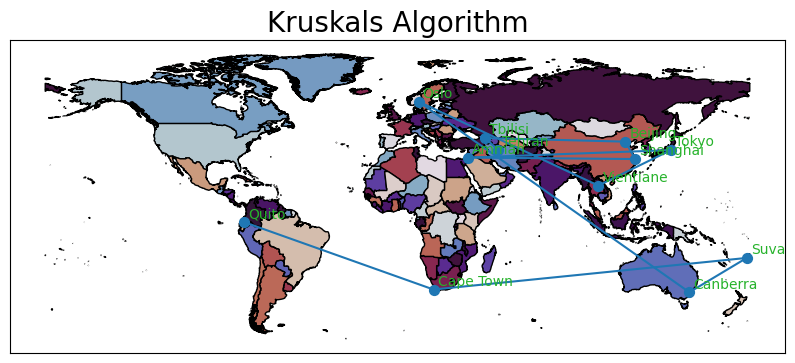

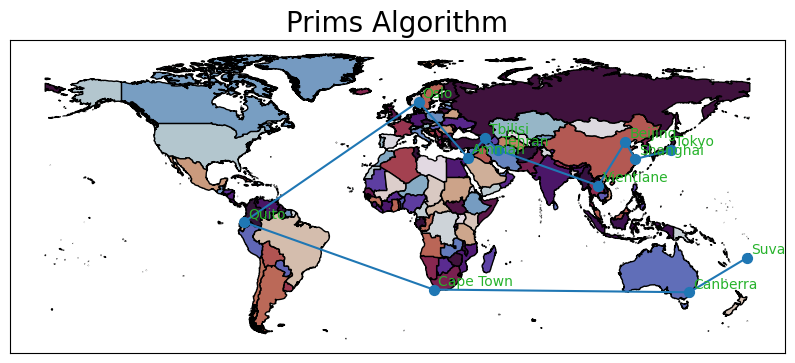

In [62]:
#test main for prims algorithm
# Main function for Prim's and Kruskal's algorithm
def main(df):
    user_input = input("Enter the cities for the MST (comma-separated, e.g., 'Milwaukee, Madison, Chicago'): ")
    selected_cities = [city.strip() for city in user_input.split(', ')]

    # Create lists to store filtered cities and city-state pairs
    filtered_cities_df = []
    city_state_pairs = []

    # Filter the DataFrame to include only the specified cities and handle duplicates
    for city in selected_cities:
        # Find entries for the city in the DataFrame
        city_data = df[df['name'] == city]

        # Check for multiple entries for the city
        if len(city_data) > 1:
            # Prompt user for the state if there are multiple entries for the city
            print(f"Multiple entries found for city '{city}'.")
            state = input(f"Please specify the state for the city '{city}': ")

            # Filter the DataFrame by the specified state
            city_data = df[(df['name'] == city) & (df['state_name'] == state)]

        elif len(city_data) == 0:
            print(f"City '{city}' not found in the dataset.")
            continue

        # If the city data is found, add the city to the filtered list and record the city-state pair
        if not city_data.empty:
            filtered_cities_df.append(city_data)
            #city_state_pairs.append((city, city_data['state_name'].values[0]))

    # Create the adjacency matrix using only the filtered cities
    adj_matrix = initialize_adjacency_matrix(df, filtered_cities_df)

    # Display the adjacency matrix for debugging
    # print("Adjacency Matrix:")
    # print(adj_matrix)

    # Prompt the user for the starting city
    start_city = input("Enter the starting city (e.g., 'Milwaukee'): ")

    # Find the starting city index
    for idx, df in enumerate(filtered_cities_df):
      if df['name'].values[0] == start_city:
        start_city_index = idx
        break


    # Run Prim's algorithm
    n = len(filtered_cities_df)
    mst_prims = prims_algorithm(adj_matrix, start_city_index, n, selected_cities, filtered_cities_df)

    # run kruskal's
    mst_kruskals = kruskals_algorithm(adj_matrix, selected_cities, filtered_cities_df)

    #Prints MST for Kruskal's
    print("Minimum Spanning Tree for Kruskal's:")
    for city1, city2, distance in mst_kruskals:
        #print(f"{city1['name'].values[0]} - {city2['name'].values[0]}: {distance} miles")
        print(f"{city1['name'].values[0]} - {city2['name'].values[0]}: {distance} miles")

    #Print the minimum spanning tree for Prim's
    print("Minimum Spanning Tree for Prim's:")
    for city1, city2, distance in mst_prims:
        #print(f"{city1['name'].values[0]} - {city2['name'].values[0]}: {distance} miles")
        print(f"{city1['name'].values[0]} - {city2['name'].values[0]}: {distance} miles")

    UX_display(mst_prims, mst_kruskals, df, US_map, world_map)
if __name__ == "__main__":
    main(df)